In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from tqdm import tqdm
from numpy import random

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Creating the Dataset for transfered learning on the ResNet Model
I am exploring the Albumentations library to perform Data Augmentation.  
The reason I have created this entire new class `DynamicAugmentedCIFAR10` is that the normal way we apply transforms in pytorch, doesn't really augment the data, i.e., There's no change in the size of the dataset but it just transforms the image.

In [3]:
class DynamicAugmentedCIFAR10(Dataset):
    def __init__(self, root='./data', train=True, download=True,
                 augment_times=1, apply_prob=0.5):
        self.base_dataset = torchvision.datasets.CIFAR10(root=root, train=train,
                                                         download=download, transform=None)
        self.augment_times = augment_times
        self.apply_prob = apply_prob
        self.total_len = len(self.base_dataset) * augment_times

        self.original_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), # Scales to [0, 1] and converts to FloatTensor
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        self.aug = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.GaussianBlur(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2() # Converts to Tensor, type depends on input
        ])

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        base_idx = idx % len(self.base_dataset)
        img, label = self.base_dataset[base_idx]
        img_np = np.array(img)

        if random.random() < self.apply_prob:
            # apply augmentation
            img_aug = self.aug(image=img_np)['image']
            # Ensure augmented image is float32 and in [0, 1] range before normalization
            if img_aug.dtype != torch.float32:
                 img_aug = img_aug.float() / 255.0 if img_aug.max() > 1.0 else img_aug.float()
            # print("Augmented image dtype after processing:", img_aug.dtype)
            # print("Augmented image shape after processing:", img_aug.shape)
            # print("Augmented image min/max after processing:", img_aug.min(), img_aug.max())

            return img_aug, label
        else:
            # return original
            img_orig = self.original_transform(img)
            # print("Original image dtype after processing:", img_orig.dtype)
            # print("Original image shape after processing:", img_orig.shape)
            # print("Original image min/max after processing:", img_orig.min(), img_orig.max())
            return img_orig, label

train_dataset = DynamicAugmentedCIFAR10(augment_times=4, apply_prob=0.7)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


class CIFAR10TestDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root='./data', train=False, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        # Apply Albumentations transform
        if self.transform is not None:
            img = self.transform(image=img)['image']
        # Ensure test image is float32 if not already
        if img.dtype != torch.float32:
             img = img.float() / 255.0 if img.max() > 1.0 else img.float()
        return img, target


test_dataset = CIFAR10TestDataset(root='./data', train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

100%|██████████| 170M/170M [00:02<00:00, 59.1MB/s] 
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train dataset size: 200000
Test dataset size: 10000


-----------------------------------------------  
# Fine Tuning ResNets (Run Only if Want to see the Training Process)

In [10]:
model1 = models.resnet50(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 10) # Changed from 2 to 10

for param in model1.parameters():
    param.requires_grad = False
for param in model1.fc.parameters():
    param.requires_grad = True

model1 = model1.to(device)

model2 = models.resnet152(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 10) # Changed from 2 to 10

for param in model2.parameters():
    param.requires_grad = False
for param in model2.fc.parameters():
    param.requires_grad = True

model2 = model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 222MB/s] 


In [ ]:
def train(model, train_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
    
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
    
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {100 * correct / total:.2f}%")

        return model

model1 = train(model1, train_loader)
model2 = train(model2, train_loader)

---
I have lost the output of the training process and It takes two long to run :/. So I'll just load the models that I had thankfully saved.

In [18]:
loaded_resnet50_model = torch.load("/kaggle/input/resnet50/pytorch/v1/1/resnet50v1.pt", weights_only=False)
loaded_resnet152_model = torch.load("/kaggle/input/resnet152/pytorch/default/1/resnet152v1.pt", weights_only=False)

100%|██████████| 157/157 [00:39<00:00,  3.99it/s]


Accuracy: 0.8832
Precision: 0.8851, Recall: 0.8832, F1-Score: 0.8830


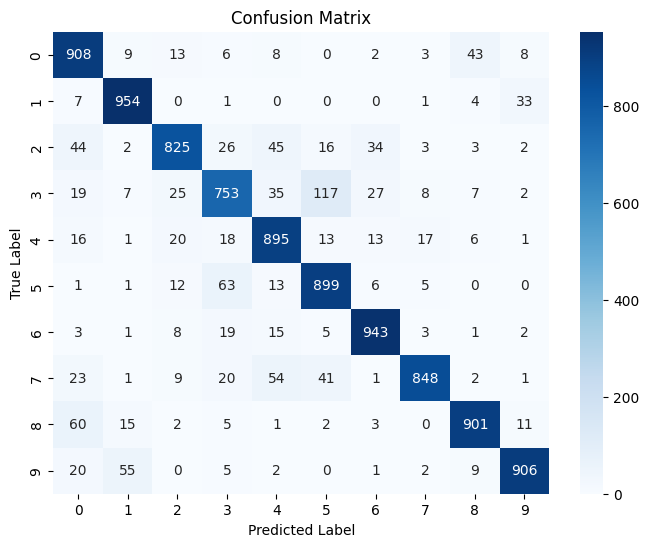

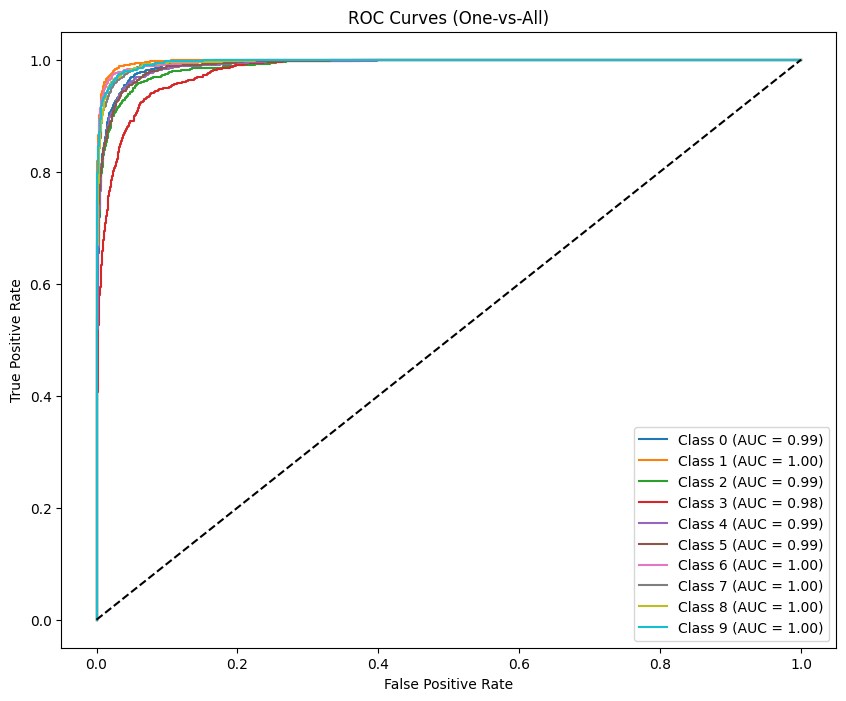

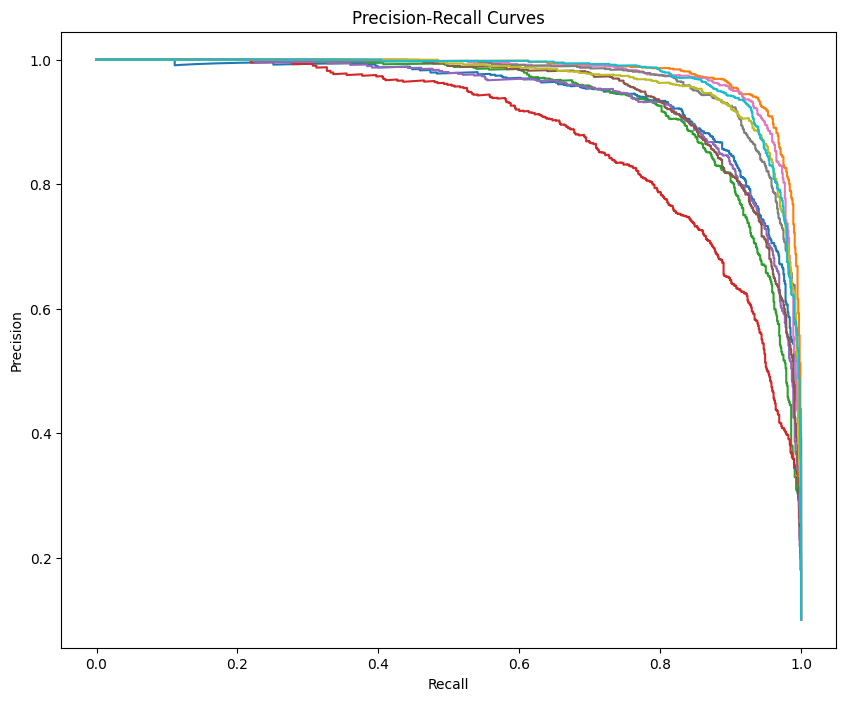

{'accuracy': 0.8832,
 'precision': 0.8851337674153406,
 'recall': 0.8832000000000001,
 'f1_score': 0.8829637928497865,
 'confusion_matrix': array([[908,   9,  13,   6,   8,   0,   2,   3,  43,   8],
        [  7, 954,   0,   1,   0,   0,   0,   1,   4,  33],
        [ 44,   2, 825,  26,  45,  16,  34,   3,   3,   2],
        [ 19,   7,  25, 753,  35, 117,  27,   8,   7,   2],
        [ 16,   1,  20,  18, 895,  13,  13,  17,   6,   1],
        [  1,   1,  12,  63,  13, 899,   6,   5,   0,   0],
        [  3,   1,   8,  19,  15,   5, 943,   3,   1,   2],
        [ 23,   1,   9,  20,  54,  41,   1, 848,   2,   1],
        [ 60,  15,   2,   5,   1,   2,   3,   0, 901,  11],
        [ 20,  55,   0,   5,   2,   0,   1,   2,   9, 906]]),
 'roc_auc': {0: 0.9927596666666666,
  1: 0.9978152222222223,
  2: 0.9891834444444444,
  3: 0.9812299999999998,
  4: 0.9909066666666667,
  5: 0.9917438888888889,
  6: 0.996315,
  7: 0.9958560000000001,
  8: 0.9957663333333333,
  9: 0.9965254444444444}}

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import os

def evaluate_model(model, dataloader, num_classes=10, save_dir="evaluation"):
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    y_score = np.concatenate(all_probs)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # for ROC-AUC

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1-Score (macro)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.close()

    # --- ROC-AUC (One-vs-All) ---
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves (One-vs-All)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(save_dir, "roc_auc_curve.png"))
    plt.close()

    # --- Precision-Recall Curves (Optional) ---
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall_curve, precision_curve, label=f"Class {i}")

    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend
    plt.show()
    plt.savefig(os.path.join(save_dir, "precision_recall_curve.png"))
    plt.close()

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "roc_auc": roc_auc
    }

evaluate_model(loaded_resnet152_model, test_loader)

100%|██████████| 157/157 [00:18<00:00,  8.33it/s]


Accuracy: 0.8556
Precision: 0.8593, Recall: 0.8556, F1-Score: 0.8552


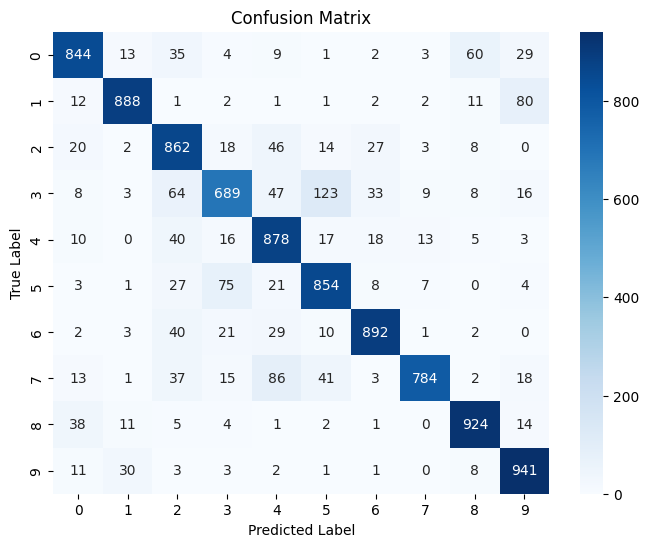

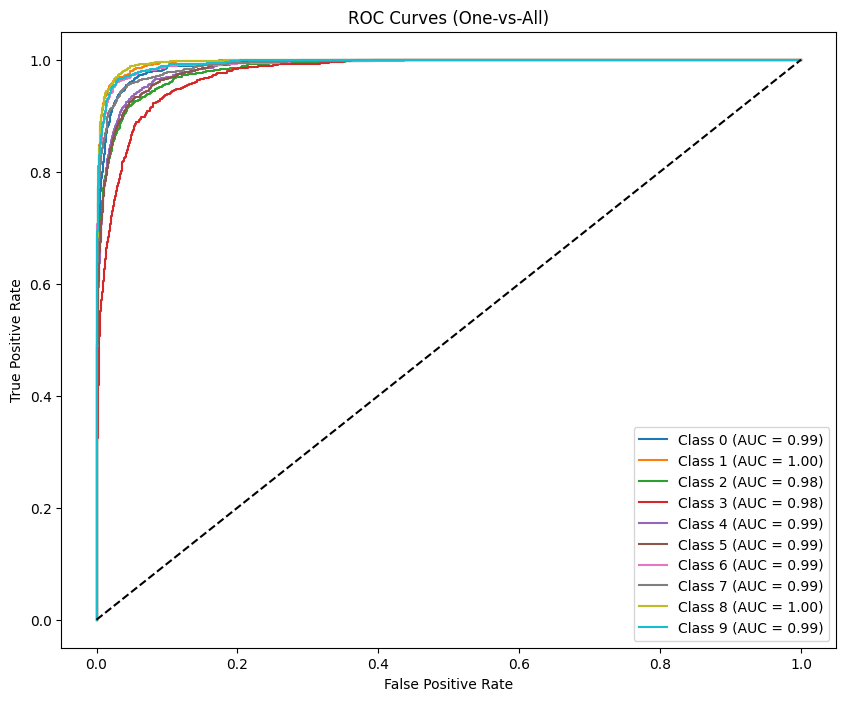

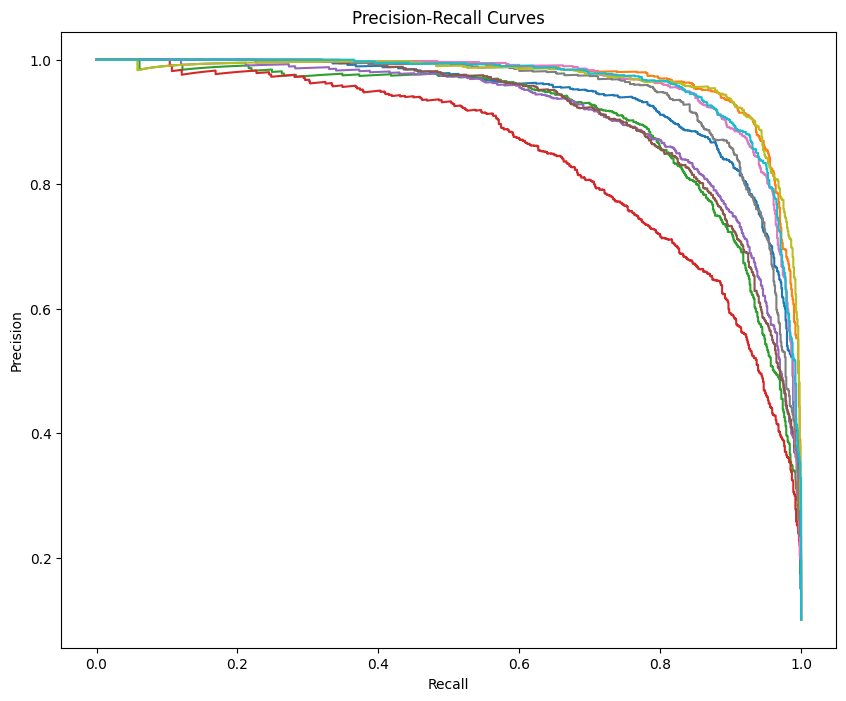

{'accuracy': 0.8556,
 'precision': 0.8592768917757855,
 'recall': 0.8556000000000001,
 'f1_score': 0.8551766021851817,
 'confusion_matrix': array([[844,  13,  35,   4,   9,   1,   2,   3,  60,  29],
        [ 12, 888,   1,   2,   1,   1,   2,   2,  11,  80],
        [ 20,   2, 862,  18,  46,  14,  27,   3,   8,   0],
        [  8,   3,  64, 689,  47, 123,  33,   9,   8,  16],
        [ 10,   0,  40,  16, 878,  17,  18,  13,   5,   3],
        [  3,   1,  27,  75,  21, 854,   8,   7,   0,   4],
        [  2,   3,  40,  21,  29,  10, 892,   1,   2,   0],
        [ 13,   1,  37,  15,  86,  41,   3, 784,   2,  18],
        [ 38,  11,   5,   4,   1,   2,   1,   0, 924,  14],
        [ 11,  30,   3,   3,   2,   1,   1,   0,   8, 941]]),
 'roc_auc': {0: 0.991131,
  1: 0.9959231111111111,
  2: 0.9843338888888888,
  3: 0.9756366666666667,
  4: 0.9867153333333332,
  5: 0.9862505555555555,
  6: 0.9932886666666666,
  7: 0.9911838888888889,
  8: 0.9961227777777778,
  9: 0.9945505555555556}}

In [17]:
evaluate_model(loaded_resnet50_model, test_loader)